# Parte II: Baseline (Regresión Logística).


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

SEED = 42
np.random.seed(SEED)


In [126]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
print('train shape:', df.shape)


train shape: (7613, 5)


## 1) Feature engineering

In [127]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)
df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

## 2) Preparar datos para entrenamiento y validación

In [128]:
print("Valores únicos en 'keyword':", df['keyword'].nunique())
print("Valores únicos en 'location':", df['location'].nunique())

Valores únicos en 'keyword': 222
Valores únicos en 'location': 3027


In [129]:
# pongo keywords y ubicaciones poco frecuentes bajo un mismo identificador
location_appearings = df['location'].value_counts().to_dict()
df['location_clean'] = df['location'].map(lambda loc: loc if location_appearings[loc] > 2 else "other")
print("Algunos valores con una aparición de location:", [loc for loc, count in location_appearings.items() if count == 1][::-1][:10])
print("Valores únicos en 'location_clean':", df['location_clean'].nunique())

keyword_counts = df['keyword'].value_counts()
kw_Q1 = keyword_counts.quantile(0.25)
low_frequency_keywords = keyword_counts[keyword_counts < kw_Q1].to_dict()
print("Algunos keywords con poca frecuencia:", [kw_count for kw_count in low_frequency_keywords.items()][::-1][:10])
df['keyword_clean'] = df['keyword'].map(lambda kw: kw if kw not in low_frequency_keywords else "other")
print("Valores únicos en 'keyword_clean':", df['keyword_clean'].nunique())

Algunos valores con una aparición de location: ['pratt on wye', 'lebanon tennessee', 'khanna', 'abuja', 'anaheim', 'sheffield township ohio', 'milky way', 'paranaque city', 'oxford oh', 'toronto citizen of canada us']
Valores únicos en 'location_clean': 280
Algunos keywords con poca frecuencia: [('radiation%20emergency', 9), ('inundation', 10), ('threat', 11), ('epicentre', 12), ('forest%20fire', 19), ('rescue', 22), ('war%20zone', 24), ('bush%20fires', 25), ('battle', 26), ('deluged', 27)]
Valores únicos en 'keyword_clean': 172


In [ ]:
num_features = ['text_len', 'word_count', 'mean_word_len',
                'num_hashtags', 'num_mentions', 'disaster_terms_count',
                'all_caps_count', 'neg', 'neu', 'pos', 'compound']
cat_features = ['location_clean', 'keyword_clean']
bool_features = ['has_url', 'has_hashtag', 'has_mention', 'location_mentioned']
emb_features = ['text_clean']
X = df[num_features + cat_features + bool_features + emb_features]
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)


Train shape: (6090, 18) Val shape: (1523, 18)


## 3) Encoding

In [131]:
loc_encoding = TargetEncoder(random_state=SEED)
loc_encoding.fit(X_train[['location_clean']], y_train)
X_train_loc_enc = loc_encoding.transform(X_train[['location_clean']])
X_val_loc_enc = loc_encoding.transform(X_val[['location_clean']])

kyw_encoding = TargetEncoder(random_state=SEED)
kyw_encoding.fit(X_train[['keyword_clean']], y_train)
X_train_kyw_enc = kyw_encoding.transform(X_train[['keyword_clean']])
X_val_kyw_enc = kyw_encoding.transform(X_val[['keyword_clean']])

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
vectorizer.fit(X_train['text_clean'])
X_train_text_emb = vectorizer.transform(X_train['text_clean']).toarray()
X_val_text_emb = vectorizer.transform(X_val['text_clean']).toarray()

X_train_final = np.hstack([X_train[num_features], X_train_loc_enc, X_train_kyw_enc, X_train[bool_features], X_train_text_emb])
X_val_final = np.hstack([X_val[num_features], X_val_loc_enc, X_val_kyw_enc, X_val[bool_features], X_val_text_emb])
print('X_train_final shape:', X_train_final.shape)

X_train_final shape: (6090, 117)


## 4) Búsqueda de hiperparámetros con GridSearchCV
Optimizamos `C` de la regresión logística usando `StratifiedKFold` y `f1` como scoring.

In [132]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [133]:
hyper_params = {
    'C': [0.5, 0.75, 0.9, 1.0, 1.1, 1.25, 1.5],
    'penalty': ['l1', None],
}

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid = GridSearchCV(clf, hyper_params, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_final, y_train)
print('Mejores hiper parametros:', grid.best_params_)
print('Mejor F1 (CV) en training:', grid.best_score_)
best_clf = grid.best_estimator_


Fitting 5 folds for each of 14 candidates, totalling 70 fits


c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Patricio\miniconda3\envs\jupyter_env\Li

Mejores hiper parametros: {'C': 0.5, 'penalty': None}
Mejor F1 (CV) en training: 0.748743336984887


c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5) Evaluación en validación

In [134]:
y_val_pred = best_clf.predict(X_val_final)
print('F1 (validación):', f1_score(y_val, y_val_pred))
print('Classification report (validación):')
print(classification_report(y_val, y_val_pred))

F1 (validación): 0.7516879219804952
Classification report (validación):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       869
           1       0.74      0.77      0.75       654

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



## 6) Importancia de features
Extraemos los coeficientes de la regresión logística para las features tabulares (num + one-hot). Para los embeddings mostramos distribuciones o top dimensiones si interesa.

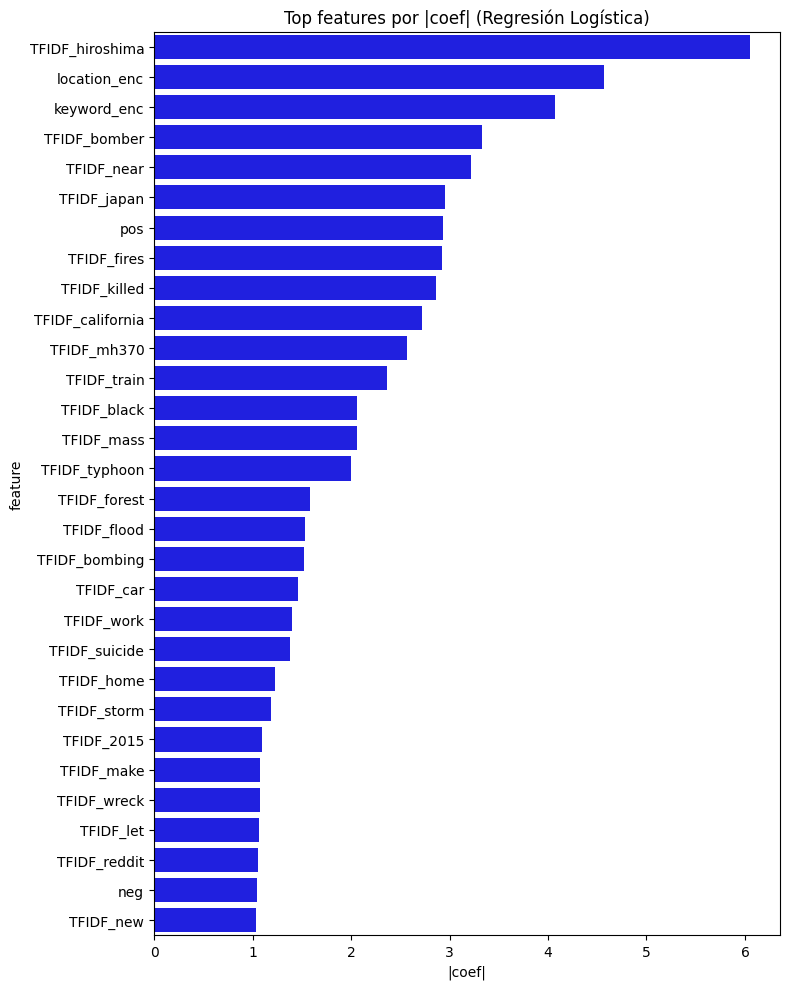

In [135]:
tfidf_col_names = [f"TFIDF_{c}" for c in vectorizer.get_feature_names_out()]
feature_names_tab = num_features + ['location_enc', 'keyword_enc'] + bool_features + tfidf_col_names
# Coefs del mejor_clf (coef_ corresponde a todas las features incl. embeddings)
coefs = best_clf.coef_[0]
# Tomamos coeficientes relativos a las features tabulares (al inicio)
n_tab = len(feature_names_tab)
tab_coefs = coefs[:n_tab]
imp_df = pd.DataFrame({'feature': feature_names_tab, 'coef_abs': np.abs(tab_coefs), 'coef': tab_coefs})
imp_df = imp_df.sort_values('coef_abs', ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x='coef_abs', y='feature', data=imp_df, color='b')
plt.title('Top features por |coef| (Regresión Logística)')
plt.xlabel('|coef|')
plt.tight_layout()
plt.show()


## 7) Predicción sobre el set de Test

In [136]:
test_path = 'data/test.csv'
df = pd.read_csv(test_path)

In [137]:
df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()

df['disaster_terms_count'] = df['text_clean'].apply(count_terms)
df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)


In [138]:
# pongo keywords y ubicaciones poco frecuentes bajo un mismo identificador
location_appearings = df['location'].value_counts().to_dict()
df['location_clean'] = df['location'].map(lambda loc: loc if location_appearings[loc] > 1 else "other")
print("Algunos valores con una aparición de location:", [loc for loc, count in location_appearings.items() if count == 1][:10])
print("Valores únicos en 'location_clean':", df['location_clean'].nunique())

keyword_counts = df['keyword'].value_counts()
kw_Q1 = keyword_counts.quantile(0.25)
low_frequency_keywords = keyword_counts[keyword_counts < kw_Q1].to_dict()
print("Algunos valores con una aparición de keyword:", [kw_count for kw_count in low_frequency_keywords.items()][:10])
df['keyword_clean'] = df['keyword'].map(lambda kw: kw if kw not in low_frequency_keywords else "other")
print("Valores únicos en 'keyword_clean':", df['keyword_clean'].nunique())

Algunos valores con una aparición de location: ['28 709672 97 376514', 'atl ga', 'sam s town', 'homewood pa', 'brussels belgium', 'niall s place saf 12 squad', 'live on webcam', 'los angeles califnordia', 'threeonefive', 'wandering']
Valores únicos en 'location_clean': 225
Algunos valores con una aparición de keyword: [('chemical%20emergency', 12), ('blaze', 12), ('ambulance', 12), ('bombed', 12), ('drowned', 12), ('thunder', 12), ('fire', 12), ('typhoon', 12), ('upheaval', 12), ('hurricane', 12)]
Valores únicos en 'keyword_clean': 170


In [139]:
test = df[num_features + cat_features + emb_features + bool_features]
test_val_loc_enc = loc_encoding.transform(test[['location_clean']])
test_val_kyw_enc = kyw_encoding.transform(test[['keyword_clean']])
test_val_text_emb = vectorizer.transform(test['text_clean']).toarray()
test_final = np.hstack([test[num_features], test_val_loc_enc, test_val_kyw_enc, test_val_text_emb, test[bool_features]])
print('test_final shape:', test_final.shape)

test_final shape: (3263, 117)


In [140]:
test_pred = best_clf.predict(test_final)

In [141]:
submission = pd.DataFrame({'id': df['id'], 'target': test_pred})
submission.to_csv('submission.csv', index=False)